<a href="https://colab.research.google.com/github/Bambaribam/class2021Spring/blob/main/learners_vanila.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

성능비교를 하기 위한 바닐라 모델(가장 기본적인 모델)
영어 텍스트가 영어 모국어 화자의 글인지, 영어를 공부하는 한국어 화자가 쓴 텍스트인지 구분하는 코드

In [3]:
def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]        
    return data

train_data = read_data('training_small.txt')
test_data = read_data('test_small.txt')

In [4]:
print(len(train_data))
print(len(train_data[0]))
print(len(test_data))
print(len(test_data[0]))

10000
3
1000
3


In [5]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
text1 = nltk.word_tokenize("It is a pleasant day today.")
nltk.pos_tag(text1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[('It', 'PRP'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('pleasant', 'JJ'),
 ('day', 'NN'),
 ('today', 'NN'),
 ('.', '.')]

In [6]:
import json
import os
from pprint import pprint

def tokenize(doc):
    return ['/'.join(t) for t in nltk.pos_tag(nltk.word_tokenize(doc))]

if os.path.isfile('train_small_docs.json'):
    with open('train_small_docs.json') as f:
        train_docs = json.load(f)
    with open('test_small_docs.json') as f:
        test_docs = json.load(f)
else:
    train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
    test_docs = [(tokenize(row[1]), row[2]) for row in test_data]
    # JSON 파일로 저장
    with open('train_small_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
    with open('test_small_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")

pprint(train_docs[0])

(['15/CD',
  'Make/NNP',
  'space/NN',
  'Devote/NNP',
  'a/DT',
  'room/NN',
  ',/,',
  'or/CC',
  'part/NN',
  'of/IN',
  'a/DT',
  'room/NN',
  ',/,',
  'to/TO',
  'movement/NN',
  './.'],
 '1')


In [7]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens)) #전체 유닛의 개수(<->type)

157715


In [10]:
text = nltk.Text(tokens, name='NMSC')
print(len(text.tokens))
print(len(set(text.tokens)))            
pprint(text.vocab().most_common(10))

157715
23122
[('./.', 9314),
 (',/,', 7708),
 ('the/DT', 5628),
 ('to/TO', 3347),
 ('and/CC', 3286),
 ('of/IN', 3226),
 ('a/DT', 2557),
 ('I/PRP', 2436),
 ('in/IN', 2038),
 ('is/VBZ', 1994)]


In [12]:
selected_words = [f[0] for f in text.vocab().most_common(1000)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_docs]
test_x = [term_frequency(d) for d, _ in test_docs]
train_y = [c for _, c in train_docs]
test_y = [c for _, c in test_docs]

In [13]:
import numpy as np

x_train = np.asarray(train_x).astype('float16')
x_test = np.asarray(test_x).astype('float16')

y_train = np.asarray(train_y).astype('float16')
y_test = np.asarray(test_y).astype('float16')

Epoch 1/20
18/18 [==============================] - 3s 22ms/step - loss: 0.6387 - binary_accuracy: 0.7031 - val_loss: 0.4410 - val_binary_accuracy: 0.8530
Epoch 2/20
18/18 [==============================] - 0s 5ms/step - loss: 0.3937 - binary_accuracy: 0.8676 - val_loss: 0.2978 - val_binary_accuracy: 0.8890
Epoch 3/20
18/18 [==============================] - 0s 5ms/step - loss: 0.2778 - binary_accuracy: 0.8951 - val_loss: 0.2449 - val_binary_accuracy: 0.9130
Epoch 4/20
18/18 [==============================] - 0s 5ms/step - loss: 0.2323 - binary_accuracy: 0.9138 - val_loss: 0.2258 - val_binary_accuracy: 0.9120
Epoch 5/20
18/18 [==============================] - 0s 5ms/step - loss: 0.2039 - binary_accuracy: 0.9216 - val_loss: 0.2327 - val_binary_accuracy: 0.9080
Epoch 6/20
18/18 [==============================] - 0s 5ms/step - loss: 0.1885 - binary_accuracy: 0.9264 - val_loss: 0.2222 - val_binary_accuracy: 0.9190
Epoch 7/20
18/18 [==============================] - 0s 5ms/step - loss: 0.1

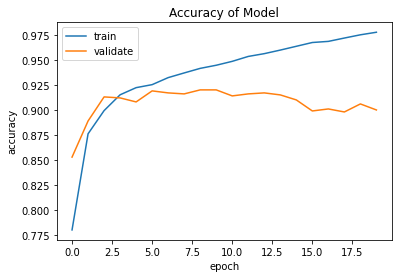

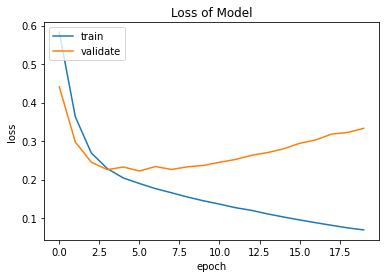

In [14]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
import matplotlib.pyplot as plt

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

hist = model.fit(x_train, y_train, validation_split=0.1, epochs=20, batch_size=512)
results = model.evaluate(x_test, y_test)

print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['binary_accuracy'])
plt.plot(hist.history['val_binary_accuracy'])
plt.title('Accuracy of Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss of Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

In [15]:
results #무려 88퍼센트의 정확도

[0.3734699785709381, 0.8799999952316284]

In [18]:
def predict(review):
    token = tokenize(review)
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data))
    if(score > 0.5):
        print("[{}]는 {:.2f}% 확률로 모국어 화자의 글이지 않을까 추측해봅니다.\n".format(review, score * 100))
    else:
        print("[{}]는 {:.2f}% 확률로 학습자의 글이지 않을까 추측해봅니다.\n".format(review, (1 - score) * 100))

In [17]:
predict("Because those drills are not that easily endure.")
predict("However I seldom read some books to recreate myself.")
predict("Also by citing his own experience, scold me for some attitude on myself.")

[Because those drills are not that easily endure.]는 99.76% 확률로 학습자의 글이지 않을까 추측해봅니다.

[However I seldom read some books to recreate myself.]는 99.85% 확률로 학습자의 글이지 않을까 추측해봅니다.

[Also by citing his own experience, scold me for some attitude on myself.]는 97.59% 확률로 학습자의 글이지 않을까 추측해봅니다.

